This is exactly the same as the OpenMM-based alanine dipeptide example, but this one uses Gromacs!

## Imports

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

from openpathsampling.engines import gromacs as ops_gmx

import mdtraj as md
import numpy as np

## Setting up the engine

Now we set things up for the Gromacs simulation. Note that all the details are in the `mdp` file, just as always with Gromacs. Currently, we need to define a few options that reproduce some of the `mdp` file; in the future, that information may be read from the `mdp`.

In [2]:
%%bash
# remove files created by previous run of this notebook
rm -rf hi_T*
rm -rf equil_*
rm -rf \#*
rm -rf initial_*.trr

In [3]:
# TODO: explain options and where files end up

In [4]:
options = {
    'gmx_executable': 'gmx -nobackup ',   # run gmx how you like it!
    'snapshot_timestep': 0.02,            # 
}  # TODO

In [5]:
hi_T_engine = ops_gmx.Engine(gro="conf.gro",
                             mdp="hi_temp.mdp",
                             top="topol.top",
                             options=options,
                             base_dir=".",
                             prefix="hi_T").named("500K")

The storage file will need a template snapshot.

In [6]:
template = hi_T_engine.current_snapshot

In [7]:
template.topology

## Defining states

First we define the CVs using the `md.compute_dihedrals` function. Then we define our states using `PeriodicCVDefinedVolume` (since our CVs are periodic.)

In [8]:
# define the CVs
psi = paths.MDTrajFunctionCV("psi", md.compute_dihedrals, template.topology, indices=[[6,8,14,16]])
phi = paths.MDTrajFunctionCV("phi", md.compute_dihedrals, template.topology, indices=[[4,6,8,14]])

In [9]:
# define the states
deg = 180.0/np.pi
C_7eq = (paths.PeriodicCVDefinedVolume(phi, lambda_min=-180/deg, lambda_max=0/deg, 
                                     period_min=-np.pi, period_max=np.pi) &
         paths.PeriodicCVDefinedVolume(psi, lambda_min=100/deg, lambda_max=200/deg,
                                     period_min=-np.pi, period_max=np.pi)
        ).named("C_7eq")
# similarly, without bothering with the labels:
alpha_R = (paths.PeriodicCVDefinedVolume(phi, -180/deg, 0/deg, -np.pi, np.pi) &
           paths.PeriodicCVDefinedVolume(psi, -100/deg, 0/deg, -np.pi, np.pi)).named("alpha_R")

## Getting a first trajectory

The idea here is a little subtle, but it makes nice use of our generalized path ensemble idea.

We want a path which contains at least one frame in each state. The question is, what ensemble can we use to create such a trajectory?

The first obvious thought would be `goal_ensemble = PartInXEnsemble(stateA) & PartInXEnsemble(stateB)` (which can, of course, be further generalized to more states). However, while that *is* the ensemble we want to eventually satisfy, we can't use its `can_append` to create it, because its `can_append` always returns `True`: the trajectory will go on forever!

But we can use a trick: since what we want is the first trajectory that satisfies `goal_ensemble`, we know that every shorter trajectory will not satisfy it. This means that the shorter trajectories must satisfy the *complement* of `goal_ensemble`, and the trajectory we want will be the first trajectory that does *not* satisfy the complement!

So the trick we'll use is to build the trajectory by using the fact that the shorter trajectories are in the complement of `goal_ensemble`, which is given by `complement = AllOutXEnsemble(stateA) | AllOutXEnsemble(stateB)`. The `generate` function will stop when that is no longer true, giving us the trajectory we want. This can be directly generalized to more states.

Note that here we're not even using the `can_append` function. That happens to be the same as the ensemble itself for this particular ensemble, but conceptually, we're actually using the test of whether a trajectory is in the ensemble at all.

In [10]:
#import logging.config
#logging.config.fileConfig("../resources/logging.conf", disable_existing_loggers=False)

In [11]:
init_traj_ensemble = paths.AllOutXEnsemble(C_7eq) | paths.AllOutXEnsemble(alpha_R)

In [12]:
# generate trajectory that includes frame in both states
trajectory = hi_T_engine.generate(hi_T_engine.current_snapshot, [init_traj_ensemble])

/Users/dwhs/miniconda3/envs/dev/lib/python3.7/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting unitcell_vectors dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


In [13]:
# create a network so we can use its ensemble to obtain an initial trajectory
# use all-to-all because we don't care if initial traj is A->B or B->A: it can be reversed
tmp_network = paths.TPSNetwork.from_states_all_to_all([C_7eq, alpha_R])

In [14]:
# take the subtrajectory matching the ensemble (only one ensemble, only one subtraj)
subtrajectories = []
for ens in tmp_network.analysis_ensembles:
    subtrajectories += ens.split(trajectory)
print(subtrajectories)

[Trajectory[42]]


## Plotting the trajectory

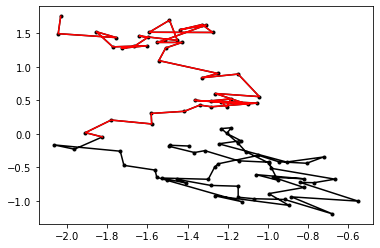

In [15]:
plt.plot(phi(trajectory), psi(trajectory), 'k.-')
plt.plot(phi(subtrajectories[0]), psi(subtrajectories[0]), 'r')

## Setting up another engine

We'll create another engine that uses a 300K integrator, and equilibrate to a 300K path from the 500K path.

In [16]:
engine = ops_gmx.Engine(gro="conf.gro",
                        mdp="md.mdp",
                        top="topol.top",
                        options=options,
                        base_dir=".",
                        prefix="equil").named("tps_equil")

## Equilibrate TPS

This is, again, a simple path sampling setup. We use the same `TPSNetwork` we'll use later, and only shooting moves. One the initial conditions are correctly set up, we run one step at a time until the initial trajectory is decorrelated.

This setup of a path sampler always consists of defining a `network` and a `move_scheme`. See toy model notebooks for further discussion.

In [17]:
network = paths.TPSNetwork(initial_states=C_7eq, final_states=alpha_R)
scheme = paths.OneWayShootingMoveScheme(network, 
                                        selector=paths.UniformSelector(),
                                        engine=engine)

In [18]:
# make subtrajectories into initial conditions (trajectories become a sampleset)
initial_conditions = scheme.initial_conditions_from_trajectories(subtrajectories)

No missing ensembles.
No extra ensembles.


In [19]:
# check that initial conditions are valid and complete (raise AssertionError otherwise)
scheme.assert_initial_conditions(initial_conditions)

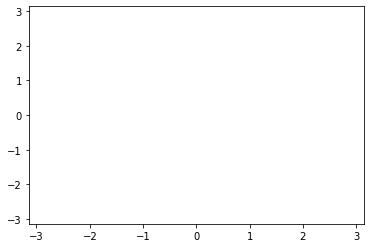

In [20]:
# TODO: for now, use an empty background -- we should change the main code to handle it correctly
(fig, ax) = plt.subplots()
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi);

In [21]:
# debug logging to test that the engine is working
import logging.config
logging.config.fileConfig("./engine_debug.conf", disable_existing_loggers=False)

In [22]:
sampler = paths.PathSampling(storage=paths.Storage("alanine_dipeptide_tps_equil.nc", "w", template),
                             move_scheme=scheme,
                             sample_set=initial_conditions)
sampler.live_visualizer = paths.StepVisualizer2D(network, phi, psi, [-np.pi, np.pi], [-np.pi, np.pi])
sampler.live_visualizer.background = fig

In [23]:
# initially, these trajectories are correlated (actually, identical)
# once decorrelated, we have a (somewhat) reasonable 300K trajectory
initial_conditions[0].trajectory.is_correlated(sampler.sample_set[0].trajectory)

True

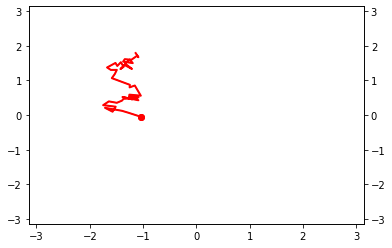

DONE! Completed 4 Monte Carlo cycles.


In [24]:
# this is a trick to take the first decorrelated trajectory
while (initial_conditions[0].trajectory.is_correlated(sampler.sample_set[0].trajectory)):
    sampler.run(1)

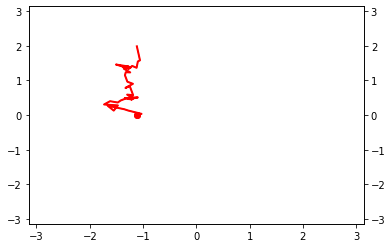

DONE! Completed 14 Monte Carlo cycles.


In [25]:
# run an extra 10 to decorrelate a little futher
sampler.run(10)

From here, you can either extend this to a longer trajectory for the fixed length TPS in the `alanine_dipeptide_fixed_tps_traj.ipynb` notebook, or go straight to flexible length TPS in the `alanine_dipeptide_tps_run.ipynb` notebook.

In [26]:
sampler.storage.close()